In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from pylab import *

import arviz as az
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
import seaborn as sns

numpyro.set_host_device_count(4)

sns.set_context('notebook')
sns.set_palette('husl')

In [17]:
def kde_model(x_samples):
    nobs, nsamp, ndim = x_samples.shape

    mu_x = np.mean(x_samples, axis=1)
    resid = x_samples - mu_x[:,newaxis,:]
    cov_x = np.mean(resid[:,:,:,newaxis]*resid[:,:,newaxis,:], axis=1)
    bw = jnp.asarray(cov_x / nsamp**(2/(4+ndim))) # Scott's rule
    xsamp = jnp.asarray(x_samples)

    mu = numpyro.sample('mu', dist.Normal(zeros(ndim), ones(ndim)))
    sigmas = numpyro.sample('sigmas', dist.HalfNormal(ones(ndim)))
    Lcorr = numpyro.sample('Lcorr', dist.LKJCholesky(ndim, concentration=2))
    L = numpyro.deterministic('L', sigmas[:,jnp.newaxis] * Lcorr)
    Sigma = numpyro.deterministic('Sigma', jnp.matmul(L, L.T))

    sigma_tot = Sigma[jnp.newaxis, jnp.newaxis, :, :] + bw[:, jnp.newaxis, :, :]
    d = dist.MultivariateNormal(mu[jnp.newaxis, jnp.newaxis, :], sigma_tot)
    logp = d.log_prob(xsamp)
    numpyro.factor('likelihood', jnp.sum(jax.scipy.special.logsumexp(logp, axis=1)))

In [34]:
Ndim = 2
Nobs = 100
Nsamp = 128
x_true = zeros(Ndim)

x_samples = []
for _ in range(Nobs):
    C = randn(Ndim,Ndim)
    C = np.dot(C, C.T)

    x_obs = np.random.multivariate_normal(x_true, C)
    x_samples.append(np.random.multivariate_normal(x_obs, C, size=Nsamp))
x_samples = array(x_samples)

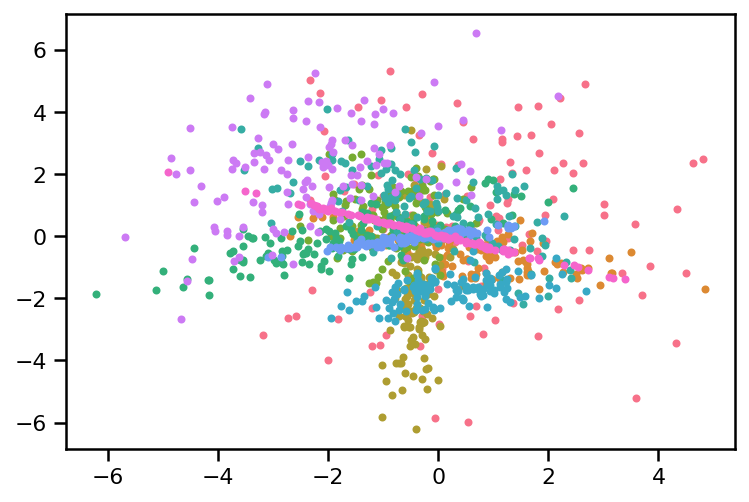

In [35]:
Nplot = 10
with sns.color_palette('husl', n_colors=Nplot):
    for i in range(Nplot):
        j = randint(Nobs)
        plot(x_samples[j,:,0], x_samples[j,:,1], '.')

In [40]:
sampler = NUTS(kde_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(randint(1<<32)), x_samples)
trace = az.from_numpyro(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigmas'}>,
        <AxesSubplot:title={'center':'sigmas'}>]], dtype=object)

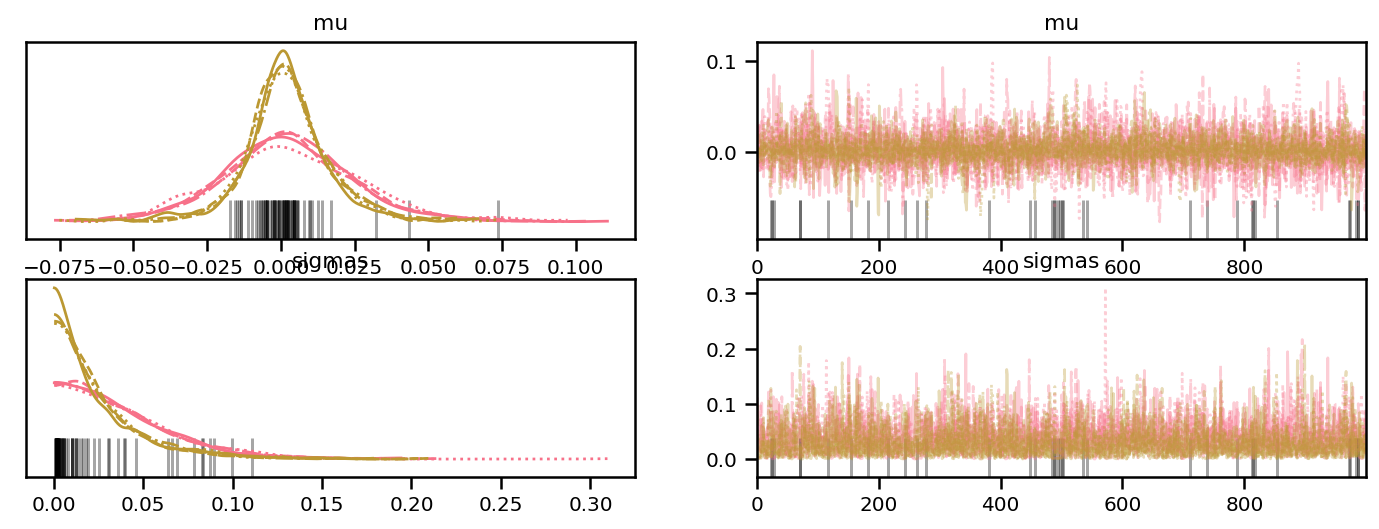

In [41]:
az.plot_trace(trace, var_names=['mu', 'sigmas'])